In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import time
import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# API
from nats_bench import create

# custom modules
from custom.sss_model import DynamicShapeTinyNet
from ZeroShotProxy import *

2023-05-19 03:45:14.246429: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-19 03:45:14.291274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 03:45:15.037117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
parser = argparse.ArgumentParser("Training-free NAS on NATSBench (SSS)")
parser.add_argument("--data_path", type=str, default='./cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space", type=str, default='sss', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./configs/nas-benchmark/algos/weight-sharing.config', help="The path to the configuration.")
parser.add_argument("--genotype", type=str, default="|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|", help="The genotype.")
parser.add_argument("--affine", type=int, default=0, choices=[0, 1], help="Whether use affine=True or False in the BN layer.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
parser.add_argument("--algo", type=str, default="training-free", help="")


# log
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")

# custom
parser.add_argument("--gpu", type=int, default=0, help="")
parser.add_argument("--workers", type=int, default=2, help="number of data loading workers")
parser.add_argument("--api_data_path", type=str, default="./api_data/NATS-sss-v1_0-50262-simple/", help="")
parser.add_argument("--save_dir", type=str, default='./results/tmp_sss', help="Folder to save checkpoints and log.")
parser.add_argument('--zero_shot_score', type=str, default='zico', help='could be: ETF; ZiCo (form ZiCo); params, (for \#Params); Zen (for Zen-NAS); TE (for TE-NAS)')
parser.add_argument("--rand_seed", type=int, default=123, help="manual seed")
args = parser.parse_args(args=[])

if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

print(args.rand_seed)
print(args)
xargs=args

123
Namespace(data_path='./cifar.python', dataset='cifar10', search_space='sss', config_path='./configs/nas-benchmark/algos/weight-sharing.config', genotype='|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|', affine=0, track_running_stats=0, algo='training-free', print_freq=200, gpu=0, workers=2, api_data_path='./api_data/NATS-sss-v1_0-50262-simple/', save_dir='./results/tmp_sss', zero_shot_score='zico', rand_seed=123)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=results/tmp_sss, use-tf=False, writer=None)
Arguments : -------------------------------
data_path        : ./cifar.python
dataset          : cifar10
search_space     : sss
config_path      : ./configs/nas-benchmark/algos/weight-sharing.config
genotype         : |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|
affine           : 0
track_running_stats : 0
algo             : training-free
print_freq       : 200
gpu              : 0
workers          : 2
api_data_path    : ./api_data/NATS-sss-v1_0-50262-simple/
save_dir         : ./results/tmp_sss
zero_shot_score  : zico
rand_seed        : 123
Python  Version  : 3.10.9 (main, Mar  8 2023, 10:47:38) [GCC 11.2.0]
Pillow  Version  : 9.4.0
PyTorch Version  : 2.0.0
cuDNN   Version  : 8500
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


In [4]:
## API
api = create(xargs.api_data_path, xargs.search_space, fast_mode=True, verbose=False)
logger.log("Create API = {:} done".format(api))

## data
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, train_loader, valid_loader = get_nas_search_loaders(train_data,
                                                                   valid_data,
                                                                   xargs.dataset,
                                                                   "./configs/nas-benchmark/",
                                                                   (config.batch_size, config.test_batch_size),
                                                                   xargs.workers,)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

## model
search_space = get_search_spaces(xargs.search_space, "nats-bench")
logger.log("search space : {:}".format(search_space))

device = torch.device('cuda:{}'.format(xargs.gpu))

def random_genotype(search_space):
    max_num_Cs = search_space['numbers']
    candidate_Cs = search_space['candidates']
    cs, cs_ = [], []
    for i in range(max_num_Cs):
        index = random.randint(0, len(candidate_Cs) - 1)
        cs.append(str(candidate_Cs[index]))
        cs_.append(candidate_Cs[index])
    return ":".join(cs), cs_

arch, c_list = random_genotype(search_space)
network = DynamicShapeTinyNet(channels = c_list, genotype=args.genotype, num_classes=class_num).to(device)

Create API = NATSsize(0/32768 architectures, fast_mode=True, file=) done
Files already downloaded and verified
Files already downloaded and verified
./configs/nas-benchmark/algos/weight-sharing.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=100, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=100, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
search space : {'candidates': [8, 16, 24, 32, 40, 48, 56, 64], 'numbers': 5}


In [5]:
def search_find_best(xargs, xloader, n_samples = None, archs = None):
    if 'etf' or 'zico' in xargs.zero_shot_score.lower():
        score_fn_name = "compute_{}_score".format(args.zero_shot_score.lower())
        score_fn = globals().get(score_fn_name)
        input_, target_ = next(iter(xloader))
        resolution = input_.size(2)
        batch_size = input_.size(0)
        zero_shot_score_dict = None
        arch_list = []
        trainloader = None if 'etf' in xargs.zero_shot_score.lower() else search_loader
    else:
        raise NotImplementedError
    
    if archs is None and n_samples is not None:
        all_time = []
        all_mem = []
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        for i in tqdm.tqdm(range(n_samples)):
            # random sampling
            arch, c_list = random_genotype(search_space)
            network = DynamicShapeTinyNet(channels = c_list, genotype=args.genotype, num_classes=class_num).to(device)
            network.train()

            start.record()
            torch.cuda.reset_peak_memory_stats()

            info_dict = score_fn.compute_nas_score(network, gpu=xargs.gpu, trainloader=trainloader, resolution=resolution, batch_size=batch_size)

            end.record()
            torch.cuda.synchronize()
            all_time.append(start.elapsed_time(end))
#             all_mem.append(torch.cuda.max_memory_reserved())
            all_mem.append(torch.cuda.max_memory_allocated())
            torch.cuda.empty_cache()
            del network

            arch_list.append(arch)
            if zero_shot_score_dict is None: # initialize dict
                zero_shot_score_dict = dict()
                for k in info_dict.keys():
                    zero_shot_score_dict[k] = []
            for k, v in info_dict.items():
                zero_shot_score_dict[k].append(v)

        print("------Runtime------")
        print("All: {:.5f} ms".format(np.mean(all_time)))
        print("------Avg Mem------")
        print("All: {:.5f} GB".format(np.mean(all_mem)/1e9))
        print("------Max Mem------")
        print("All: {:.5f} GB".format(np.max(all_mem)/1e9))
        
    elif archs is not None and n_samples is None:
        all_time = []
        all_mem = []
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        for arch in tqdm.tqdm(archs):
            # random sampling
            network = DynamicShapeTinyNet(channels = arch, genotype=args.genotype, num_classes=class_num).to(device)
            network.train()

            start.record()
            torch.cuda.reset_peak_memory_stats()

            info_dict = score_fn.compute_nas_score(network, gpu=xargs.gpu, trainloader=trainloader, resolution=resolution, batch_size=batch_size)

            end.record()
            torch.cuda.synchronize()
            all_time.append(start.elapsed_time(end))
#             all_mem.append(torch.cuda.max_memory_reserved())
            all_mem.append(torch.cuda.max_memory_allocated())
            torch.cuda.empty_cache()

            arch_list.append(arch)
            if zero_shot_score_dict is None: # initialize dict
                zero_shot_score_dict = dict()
                for k in info_dict.keys():
                    zero_shot_score_dict[k] = []
            for k, v in info_dict.items():
                zero_shot_score_dict[k].append(v)

        print("------Runtime------")
        print("All: {:.5f} ms".format(np.mean(all_time)))
        print("------Avg Mem------")
        print("All: {:.5f} GB".format(np.mean(all_mem)/1e9))
        print("------Max Mem------")
        print("All: {:.5f} GB".format(np.max(all_mem)/1e9))
        
    return arch_list, zero_shot_score_dict

In [7]:
######### search across random N archs #########
archs, results = search_find_best(xargs, train_loader, n_samples=500)

# # ######### search across all archs #########
# def generate_all_archs(search_space, api):
#     max_num_Cs = search_space['numbers']
#     candidate_Cs = search_space['candidates']
    
#     archs = []
#     c_lists = []
#     for i in range(len(candidate_Cs)**max_num_Cs):
#         index_list = []
#         for _ in range(max_num_Cs):
#             index_list.insert(0, i % len(candidate_Cs))
#             i //= len(candidate_Cs)
#         arch, c_list = [], []
#         for idx in index_list:
#             arch.append(str(candidate_Cs[idx]))
#             c_list.append(candidate_Cs[idx])
#         archs.append(":".join(arch))
#         c_lists.append(c_list)
#     return archs, c_lists

# archs, all_c_lists = generate_all_archs(search_space, api)
# _, results = search_find_best(xargs, train_loader, archs=all_c_lists)

100%|██████████| 500/500 [02:57<00:00,  2.82it/s]

------Runtime------
All: 337.05141 ms
------Avg Mem------
All: 0.22310 GB
------Max Mem------
All: 0.37940 GB


In [13]:
def get_results_from_api(api, arch, dataset='cifar10', epoch=90):
    dataset_candidates = ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120']
    assert dataset in dataset_candidates
    index = api.query_index_by_arch(arch)
    api._prepare_info(index)
    archresult = api.arch2infos_dict[index][str(epoch)]
    
    if dataset == 'cifar10-valid':
        acc = api.get_more_info(index, dataset, iepoch=None, hp=str(epoch), is_random=False)['test-accuracy']
    else:
        acc = api.get_more_info(index, dataset, iepoch=None, hp=str(epoch), is_random=False)['test-accuracy']
    flops = archresult.get_compute_costs(dataset)['flops']
    params = archresult.get_compute_costs(dataset)['params']
    
    return acc, flops, params

api_test_accs, api_flops, api_params = [], [], []
for a in archs:
    test_acc, flops, params = get_results_from_api(api, a, 'cifar10')
#     test_acc, flops, params = get_results_from_api(api, a, 'cifar100')
#     test_acc, flops, params = get_results_from_api(api, a, 'ImageNet16-120')
    api_test_accs.append(test_acc)
    api_flops.append(flops)
    api_params.append(params)

56:64:56:48:64
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=28591
cifar10-valid  FLOP=217.64 M, Params=0.588 MB, latency=19.71 ms.
cifar10-valid  train : [loss = 0.007 & top1 = 99.94%], valid : [loss = 0.393 & top1 = 90.19%], test : [loss = 0.424 & top1 = 89.55%]
cifar10        FLOP=217.64 M, Params=0.588 MB, latency=19.71 ms.
cifar10        train : [loss = 0.010 & top1 = 99.88%], test  : [loss = 0.258 & top1 = 93.09%]
cifar100       FLOP=217.64 M, Params=0.594 MB, latency=24.37 ms.
cifar100       train : [loss = 0.233 & top1 = 94.52%], valid : [loss = 1.178 & top1 = 70.14%], test : [loss = 1.122 & top1 = 70.04%]
ImageNet16-120 FLOP= 54.42 M, Params=0.595 MB, latency=23.23 ms.
ImageNet16-120 train : [loss = 1.653 & top1 = 55.51%], valid : [loss = 2.106 & top1 = 46.70%], test : [loss = 2.154 & top1 = 45.50%]
aggregated: 0.6984880323087648	0.8813775000443806	0.8813775000443805	


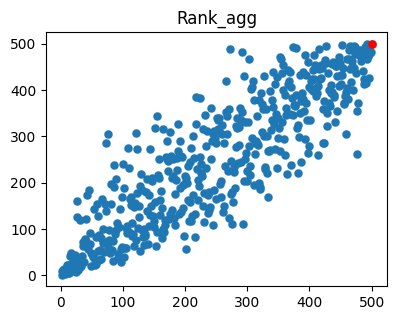

FLOPs: 0.4167719953003212	0.5739354133172967	0.5739354133172969	


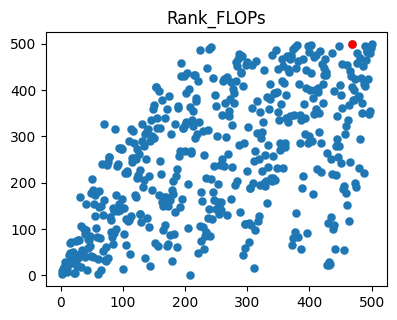

Params: 0.6498493982204586	0.8390022884144847	0.8390022884144844	


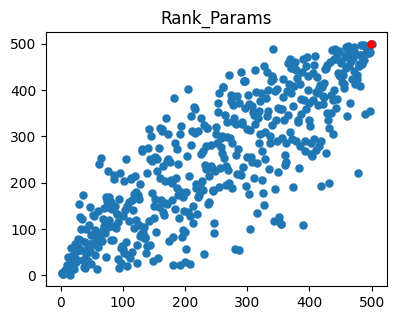

zico: 0.6984880323087648	0.8813775000443806	0.8813775000443805	


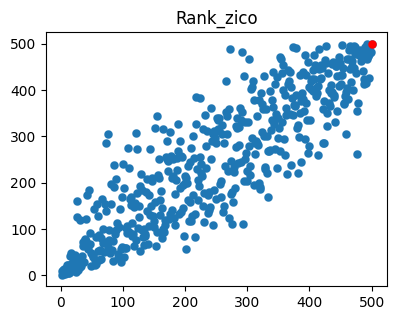

In [16]:
fig_scale = 1.1

l = len(api_flops)
rank_agg = stats.rankdata(results['zico'])
# rank_agg = np.log(stats.rankdata(api_flops) / l)
# for k in results.keys():
#     rank_agg = rank_agg + np.log( stats.rankdata(results[k]) / l)
    
# rank_agg = None
# for k in results.keys():
#     if rank_agg is None:
#         rank_agg = np.log( stats.rankdata(results[k]) / l)
#     else:
#         rank_agg = rank_agg + np.log( stats.rankdata(results[k]) / l)

# rank_agg = np.log( stats.rankdata(results['info_flow']) / l)
# rank_agg = np.log( stats.rankdata(api_params) / l)
    
best_idx = np.argmax(rank_agg)

best_arch, acc = archs[best_idx], api_test_accs[best_idx]
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "90")))
    

x = stats.rankdata(rank_agg)
y = stats.rankdata(api_test_accs)
kendalltau = stats.kendalltau(x, y)
spearmanr = stats.spearmanr(x, y)
pearsonr = stats.pearsonr(x, y)
print("aggregated: {}\t{}\t{}\t".format(kendalltau[0], pearsonr[0], spearmanr[0]))
plt.figure(figsize=(4*fig_scale,3*fig_scale))
plt.scatter(x, y, linewidths=0.1)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
plt.title("Rank_agg")
plt.show()


# for each
metrics = {'FLOPs':api_flops, 'Params':api_params}
for k, v in results.items():
    metrics[k] = v
for k in metrics.keys():
    x = stats.rankdata(metrics[k])
    y = stats.rankdata(api_test_accs)
    kendalltau = stats.kendalltau(x, y)
    spearmanr = stats.spearmanr(x, y)
    pearsonr = stats.pearsonr(x, y)
    print("{}: {}\t{}\t{}\t".format(k, kendalltau[0], pearsonr[0], spearmanr[0]))
    plt.figure(figsize=(4*fig_scale,3*fig_scale))
    plt.scatter(x, y, linewidths=0.1)
    plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
    plt.title("Rank_{}".format(k))
    plt.show()

In [ ]:
i = np.argmax(metrics['info_flow'])
print(archs[i])
print(np.max(metrics['info_flow']))